# Step4 演習02 ロジスティック回帰からニューラルネットへ
---

Step4では手書き数字の認識(Optical Character Recognition; OCR)を実装します。

まずはロジスティック回帰で実装を行い、モデルやパラメータを変更することによってスコアへどのような影響があるか体験してもらいます。

今回はscikit-learnを利用して実装を行います。

OCRはマルチクラス分類問題ですが、scikit-learnの`LogisticRegression()`を使うとオプションなしで一対多分類器として動いてくれるため、とても簡単にOCRを実装できます。

次に、ニューラルネットワークでロジスティック回帰を実装します。

多層のニューラルネットワークへの学習（ディープラーニング）もパラメータを変えるだけで実現できるので、学習にかかる時間とスコアの違いを身をもって体感してください。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での使用は避けてください。

**本演習の目的**
- 学習に使う訓練例の数を変えることでスコアにどのような影響があるのか確かめる。

## ライブラリのインポート

まずはじめに、利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [scikit-learn](http://scikit-learn.org/stable/index.html) Pythonのオープンソース機械学習ライブラリの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番に**順次実行してください。

** 注意： **初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

## 今回使うデータに関して
数字OCRのサンプルデータとしてMNISTが有名です。MNISTは手書き数字の画像のデータセットになっています。機械学習業界の"Hello, world!"ということができるでしょう。これからMNISTとはいったいどういったものなのか使用するデータの性質をみていきましょう。

「0」から「9」までの10種類の数字をこれから判別します。

In [2]:
num_labels = 10 #「0」から「9」の数字をこれから判別します。

## MNISTデータのロード
データをロードします。
mldata.orgからMNIST originalデータをダウンロードします。使用している回線によっては時間がかかる場合があります。

一度ダウンロードしたらキャッシュしますので、再度走らせるときはダウンロードの時間がかかりません。

In [3]:
mnist = datasets.fetch_mldata('MNIST original')

今回使用するMNISTの画像の枚数は70000枚、画像データのと特徴は28x28 = 784ピクセルです。

- 画像データの数：70000枚
- 画像データの特徴：28x28 = 784ピクセル

下のセルを実行することで画像データの数を** num_data **に、画像データの特徴を** input_layer_size  ** にそれぞれ格納します。


In [4]:
num_data, input_layer_size = mnist.data.shape #70000枚の28x28=784ピクセルの画像です

In [5]:
print("訓練データ数：{}".format(num_data))
print("訓練データの特徴の数：{}".format(input_layer_size))

訓練データ数：70000
訓練データの特徴の数：784


## データのシャッフル
MNIST originalデータをシャッフルしてその冒頭3000サンプルだけ訓練データとして利用することにします。

今回使用するMNISTデータのサンプル数は70000です。この全てを訓練データとして使ってしまうと、学習に使用しなかったデータに対しても正しく予測してくれるのか判断する方法がなくなってしまいます。試作段階では全てのデータを学習に用いてはいけません。（詳しくはStep5で学びます）

また今回10分の1未満のデータせセットしか学習に使わないのは別の理由もあります。マシンスペックの関係で、膨大なデータを用いると学習がなかなか終わらないためです。今回は3000サンプルのみを使用します。

ここで3000サンプルをピックアップする前にデータをシャッフルするのは何故でしょうか。例えば、データがラベル(y)に対してソートされていたとします。すると、そのまま冒頭3000サンプルを取ってしまうと、0, 1と書いてあるデータばかりが集まってしまうことになってしまいます。ぱっと見で分からないような規則でソートされている可能性もあるので、一見バラバラに見えても必ず最初にシャッフルしましょう。

下のセルを実行すると3000サンプルをランダムにシャッフルしたデータを、** X ** と ** y ** にそれぞれ格納してくれます。

In [6]:
shuffle_idx = np.random.permutation(num_data)
X = mnist.data[shuffle_idx[:3000]]   # ランダム化された画像データ3000枚
y = mnist.target[shuffle_idx[:3000]] # 各画像（3000枚）に書かれている数字（「正しい答え」）

データのシャッフルはscikit-learnのtrain_test_splitを使うこともできます。これは訓練用のデータとテスト用のデータを分けてくれるので便利です。習熟したらscikit-learnチュートリアルを読んでこれを使いましょう。

参考：
[scikit-learnチュートリアル sklearn.cross_validation.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split)

訓練例の数(3000個)は`m`、特徴の数(784ピクセル)は`n`に格納します。

In [7]:
m, n = X.shape #訓練例の数はm, 特徴の数はn

In [8]:
print("訓練例の数：{}".format(m))
print("特徴の数：{}".format(n))

訓練例の数：3000
特徴の数：784


## データの視覚化
使用するデータの準備ができました。ここではランダムに並べた最初の画像を表示させてみます。

配列`X`には3000枚の画像データ(pixel)が、一列に並んで入っています。（`X`の`shape`は`(3000, 784)`）

この画像を表示させるには、一列に並んでしまっている`3000`枚の画像データをそれぞれ２次元`(28, 28)`に戻す必要があります。それには`reshape`を使います。

下の画像は一枚の数字データに対してreshapeを行なったイメージ図です。

<div align="center"  style="width:70%">
<img src="./dataStep4/img_reshape.png"></div>

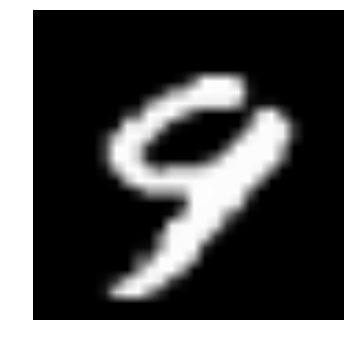

数字 9


In [9]:
X_reshaped = X.reshape((3000, 28, 28))

plt.imshow(X_reshaped[0,:,:])
plt.axis("off")
plt.gray()
plt.show()

print("数字 {0:1.0f}".format(y[0]))

一つだけでは見栄えがしないので、100個表示させるプログラムを関数（ `displayData(images)` ）として実装しておきましょう。

In [10]:
def displayData(images):
    images_reshaped = images.reshape((100, 28, 28))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(images_reshaped[i,:,:])
        plt.axis("off")
        plt.gray()
    plt.show()

これを使って、訓練データから冒頭100個選んで視覚化しましょう。多少表示に時間がかかります。

セルの左、In [何某]のところが＊になっているとき、そのセルは実行中です。

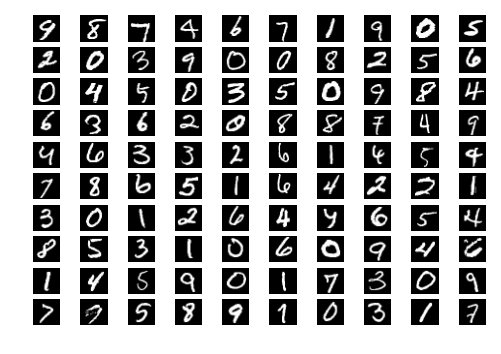

In [11]:
displayData(X[:100, :])

---
## 訓練例の数を変えてみる
訓練例を増やせばスコアを上げることができるのでしょうか。試してみましょう。

**【課題２】** 訓練例の数を6000個に変えて、新たな2000個のデータに対するスコアを求めてみよう。

Pythonでは関数が利用できるようにインポート文（例えば「import numpy as np」）を利用します。演習問題のセル内で明示的に利用する関数がある場合は（例えば、np.dot() ）、そのために必要なライブラリのインポート文は演習問題のセル内に全て入れるようにして下さい。

** ヒント：　** <br>
- データのシャッフル使ったコード（mnist.data[shuffle_idx[:3000]]）を使いましょう。ここでは3000枚のデータセットを使っていました。
- estimatorにはLogisticRegression()を使います。パラメータはすでに記述されているものを指定しましょう。 
- estimator.fit()には学習させたいデータセットを引数として渡してください。

In [14]:
#Coursemale-02 Step4 QuestionNumber2 c5f70614ac529362c9bb76861be54a55
###############ここを穴埋めしてください###############
X6 = mnist.data[shuffle_idx[:6000]]
y6 = mnist.target[shuffle_idx[:6000]]

C = 10 #正則化パラメータλの逆数のようなもの
fit_iter = 50 #勾配法の繰返し回数

estimator = LogisticRegression(penalty='l2', C=10, max_iter=50) #一対他分類
estimator.fit(X6,y6)
######################################################

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [15]:
%%bash
./validation_client.py male-02 4 2 Step4_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



下のセルを実行すると訓練例における学習精度が出力されます。

In [16]:
accuracy_train = estimator.score(X6, y6)
print("訓練例に対するスコアは",accuracy_train * 100,"%")

訓練例に対するスコアは 99.81666666666666 %


かなりいいスコアになっているはずです。
<br><br>
では次に下のセルを実行しましょう。ここでは訓練に使わなかったデータセットを使ってスコアをみてみます。

In [17]:
X6_test = mnist.data[shuffle_idx[6000:8000]]
y6_test = mnist.target[shuffle_idx[6000:8000]]
accuracy_test = estimator.score(X6_test, y6_test)

print("新たなデータに対するスコアは", accuracy_test * 100, "%")

新たなデータに対するスコアは 83.75 %


訓練例を倍にしたのに、新たなデータに対するスコアはあまり変わらないようです。

---
## 訓練例の数を変えるとスコアはどのくらい変わるのか—学習曲線

訓練例の数を例えば、１００，２００，３００．．．と順次変えていき、その都度訓練データと訓練データ以外のスコアを計測してみます。そのとき両者にはどのような関係があり、どのくらいスコアが変わるのでしょうか。グラフを書いてみましょう。訓練例の数に対するスコアのグラフのことを学習曲線といいます。

この曲線は訓練例の数を変更する毎に何度も学習し直すので、描画までの計算に時間がかかります。

訓練例に対するスコアのことを**学習スコア**(Training Score)、モデルの正解率を検証するために取っておいたデータに対するスコアのことを**交差検証スコア**(Cross Varidation Score)といいます。

下のセルに学習曲線を描画する関数を用意しましたので、実行してみてください。

In [18]:
def learning_curve_plot(estimator, X, y, train_sizes):
    plt.figure()
    plt.title(u"学習曲線")
    plt.xlabel(u"訓練例の数")
    plt.ylabel(u"スコア")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, n_jobs=2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.ylim(ymax=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="学習スコア")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="交差検証スコア")
    plt.legend(loc="best")
    plt.show()

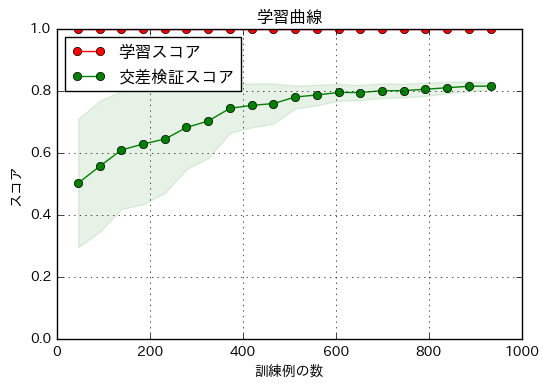

In [19]:
learning_curve_plot(estimator, mnist.data[shuffle_idx[:]], mnist.target[shuffle_idx[:]], np.linspace(0.001, 0.02,20))

訓練数600個付近で頭打ちになってしまうことが分かります。これから何千、何万と増やしても、データ収集や学習にかかる時間が無駄になってしまうでしょう。このように、学習曲線は今後の開発の方針に有意義な示唆を与えます。